
# `YData Synthetic` and `Data Profiler`: Streamlined data synthesis and profiling

`YData Synthetic` provides tools for quickly setting up a data synthesis project, trying out different models, datasets, and parameterizations. It is easy to get lost in the process of experimentation and model tweaking but, at the end of the day, quality assessment is extremely important and should not be disregarded, we need to validate that the synthetic data is suitable for our purposes, right?

When assessing the quality of the synthetic outputs we focus on two main aspects:

* Privacy, does the generated data leak any sensitive information? (Names, addresses, combinations of features that can make a real-world record identifiable)
* Utility, how well does the synthetic data preserve the original data properties? (Marginal distributions, correlations)

There are no simple ways of doing this important part of the work from scratch, that is why we are showing you today a good addition to your toolbox! This notebook shows you how to integrate the [Data Profiler](https://github.com/capitalone/DataProfiler) package on a `YData Synthetic` project. By combining these two packages you can easily synthesize data and profile it to assess the quality of the generated data.

The demo will take the following steps:

1. Install `DataProfiler` and import required packages
2. Read a dataset
3. Profile the dataset
4. Data processing
5. Define and fit a synthesizer
6. Sample and post-process synthetic data
7. Profiling synthetic data and comparing samples
8. Saving/loading a profile for later analysis

By the end of the notebook we will have covered basic `DataProfiler` usage in a data synthesis flow. We will focus the data pre-processing and its impact on the utility of the produced samples. `DataProfiler` will provide us with the necessary inputs to understand what pre-processing leads to the best results.

That's enough for an introduction, let's get started!


## 1. Install `DataProfiler` and import required packages

`DataProfiler` is a package that helps you do data analysis with a focus on profiling and sensitive data detection. In this demo we will use the slimmer version and leverage Profiler reports and graphical utilities, we will focus on the utility aspect.

To install the package we just need to uncomment and run the following cell:

In [48]:
#!pip install DataProfiler[reports]

Now we import all the required packages for this notebook.

In [49]:
from pprint import pprint
import matplotlib.pyplot as plt

from pandas import read_csv, cut, DataFrame
from numpy.random import randint, normal
from IPython.display import display
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.regular.processor import RegularDataProcessor
from dataprofiler import Profiler, graphs

If you are using GPU you might need to allow memory growth:

In [50]:
from tensorflow import config
physical_devices = config.list_physical_devices('GPU') 
for device in physical_devices:
    config.experimental.set_memory_growth(device, True)

## 2. Read a dataset

The dataset that we will use in this demo is sampled from the popular [cardio](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset).

We produced this sample by cleaning out some outliers that are extremely unlikely or even physically impossible by enforcing the following conditions:

* Diastolic (lower) pressure must be bigger than 0
* Systolic pressure (higher) must not be bigger than 240 (above [hypertensive crisis](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings))
* Diastolic pressure must be lower than the systolic blood pressure values

By applying these criteria we filtered out roughly 1.9% of the records and made the sample much more representative of a real population.


In [51]:
data = read_csv('../../data/cardio_sample.csv')
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 3. Profile the dataset
To quickly learn more about our data, we can have a look at what `DataProfiler` can provide.

The `Profiler` is the main class that unlocks data analysis.

Depending on the passed data object either an `UnstructuredProfiler`, specialized for text data, or a `StructuredProfiler`, specialized for tabular data, will be automatically dispatched.

Creating a `Profiler` for the smoker sample is simple.

In [ ]:
smoker_data = data.loc[data.smoke == 1].drop(columns='smoke')
smoker_profile = Profiler(smoker_data)

There is a lot of information to unpack from this object, we will focus on what is most informative to our task.

In [53]:
base_report = smoker_profile.report()
pprint({k:v for k,v in base_report['global_stats'].items() if k!='chi2_matrix'})

{'column_count': 11,
 'correlation_matrix': None,
 'duplicate_row_count': 0,
 'encoding': None,
 'file_type': "<class 'pandas.core.frame.DataFrame'>",
 'profile_schema': defaultdict(<class 'list'>,
                               {'active': [9],
                                'age': [0],
                                'alco': [8],
                                'ap_hi': [4],
                                'ap_lo': [5],
                                'cardio': [10],
                                'cholesterol': [6],
                                'gender': [1],
                                'gluc': [7],
                                'height': [2],
                                'weight': [3]}),
 'row_count': 6041,
 'row_has_null_ratio': 0.0,
 'row_is_null_ratio': 0.0,
 'samples_used': 5000,
 'times': {'row_stats': 0.0022242069244384766},
 'unique_row_ratio': 1.0}


From the global part of the report we can see that we have no duplicated rows, no missing values and also we get some general information about the dataset schema.

Despite not being necessary, in this case, a complete picture on missing data could be obtained with the `Graph` module's `plot_missing_values_matrix` method. It's output lets us know the prevalence of missing values, at which columns they occur and what are the inferred missing values.

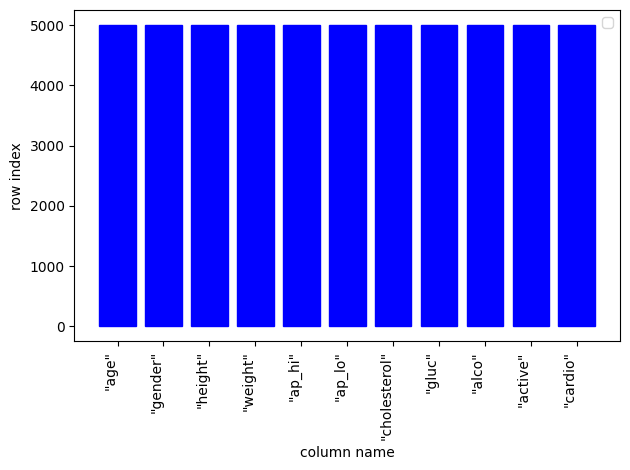

In [54]:
display(graphs.plot_missing_values_matrix(smoker_profile))
plt.close()

The blue bars mean we have no missing data.

Lets look at the feature level information and extract some more knowledge about the dataset.

In [55]:
def summarize_data_stats(data_stats, show_feats = None):
    "This function will help us preserving only the most indicative elements of the report in our analysis."
    summarized = {}
    stats_exclude_keys = ['avg_predictions', 'data_label_representation', 'data_type_representation', 'histogram', 'times', 'precision', 'label_representation', 'categorical_count', 'categories', 't-test']
    for feat_info in data_stats:
        name = feat_info['column_name']
        if show_feats and name not in show_feats:
            continue
        stats = {k: v for k, v in feat_info.pop('statistics').items() if k not in stats_exclude_keys}
        feat_info['statistics'] = stats
        summarized[name] = feat_info
    return summarized

# Looking at some feature
show_feats = ['age','ap_lo', 'ap_hi']

pprint(summarize_data_stats(base_report['data_stats'], show_feats))

{'age': {'categorical': False,
         'column_name': 'age',
         'data_label': 'INTEGER',
         'data_type': 'int',
         'order': 'random',
         'samples': ['19890', '21809', '19714', '22499', '23199'],
         'statistics': {'kurtosis': -0.9818219509492989,
                        'max': 23687.0,
                        'mean': 19076.8908,
                        'median': 19125.727499999997,
                        'median_abs_deviation': 1992.522916666669,
                        'min': 14292.0,
                        'mode': [18214.4125],
                        'null_count': 0,
                        'null_types': [],
                        'null_types_index': {},
                        'num_negatives': 0,
                        'num_zeros': 0,
                        'quantiles': {0: 16960.179999999993,
                                      1: 19125.727499999997,
                                      2: 21098.090312499997},
                        'sample_s

Unpacking some of what we can see from this report:

* Age seems to be provided as days
* There are a lot of unique values for the age feature but, according to the descriptive statistics, it is not uniform or normal distributed
* According to the samples values of ap_hi and ap_lo, this feature seems to be grouped as 10's. However the number of unique values suggests the opposite

These are some useful insights for us to consider when preprocessing the data.

From the `Graph` module we can also get a glimpse of the empirical distributions of the features with `plot_histograms`.

These methods return `matplotlib` figures which also allows you to do some further customization.

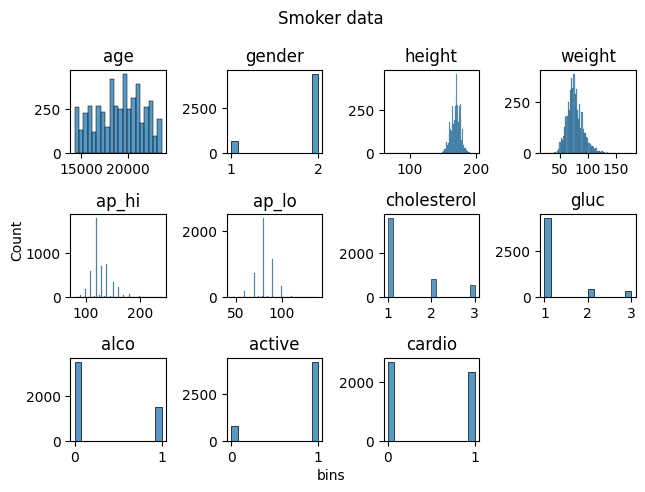

In [56]:
marginals = graphs.plot_histograms(smoker_profile)
marginals.suptitle('Smoker data')
marginals.tight_layout()

plt.show()

Now we also know the following:

* Age, ap_hi and ap_lo seem to exhibit a strong multimodal behavior. We might want to discretize these features
* Height and weight seem almost normal, but right-tailed, they can probably be reasonably well fit with a log-normal distribution

We will take these insights for the data pre-processing.

## 4. Data preprocessing
We have detected some feature distributions that probably will be hard to pick up by the GANs. We will do a custom pre-processing flow to try to concentrate the information of our features so that the data relationships can be more easily picked-up.

Starting with some feature engineering:
* For the age we will convert days to years and bin them in ranges of 5
* Relative to the blood pressure values, rounding to nearest 10's should also provide decent results, we have noticed that most of the values are actually already in this format. Also it is similar to way physicians read arterial pressure values on checkup consultations!

This preprocessing flow will leave us with a lot of categorical features. Categorical distributions are [tricky to capture](https://github.com/ydataai/ydata-synthetic/blob/dev/examples/regular/gumbel_softmax_example.ipynb) as well. In order to avoid modelling categorical distributions we will pass a dense representation of the data to the GANs. Some dimensionality reduction techniques from `Scikit learn` are suitable to obtaining a dense representation of the data.
To test the hypothesis that this additional processing step helps in GAN learning, we will split our flow in two and create two training datasets:
1. Only pre-processing the features as explained above
2. Applying a dimensionality reduction technique to the output of step one.

### 4.1 - Feature Engineering
#### Age feature

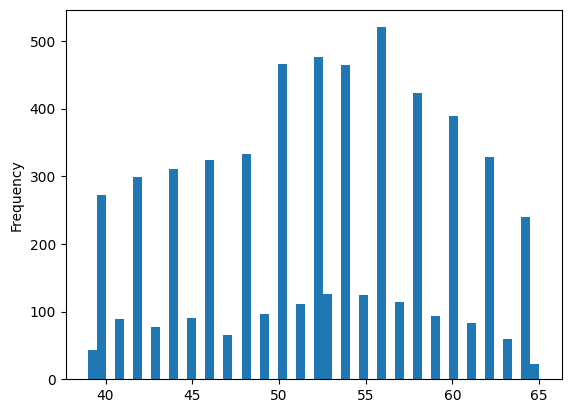

In [57]:
train1 = smoker_data.copy()

# Convert to years
train1.age = (train1.age/365).round(0)

# Plot the before
plt.figure()
train1.age.plot(kind='hist', bins=50)
plt.show()

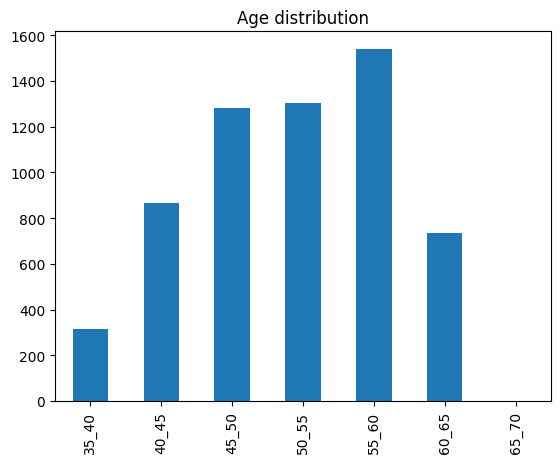

In [58]:
# Group age in year bins
g_s = 5  # Size of the bins

bins = [i for i in range(int(train1.age.min()-train1.age.min()%g_s), int(train1.age.max() + 2*g_s), g_s)]
bin_labels = [f'{i}_{i+g_s}' for i in bins[:-1]]

train1.age = cut(train1.age, bins=bins, labels=bin_labels, include_lowest=True)

# Plot the after
plt.figure()
ax = train1.age.value_counts().sort_index().plot(kind='bar')
plt.title('Age distribution')
plt.show()

#### Arterial pressure features

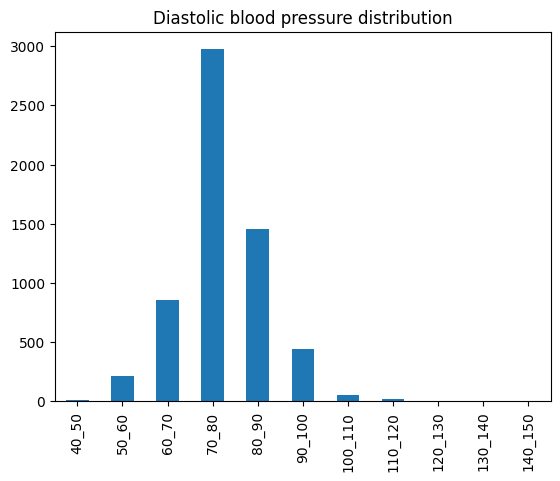

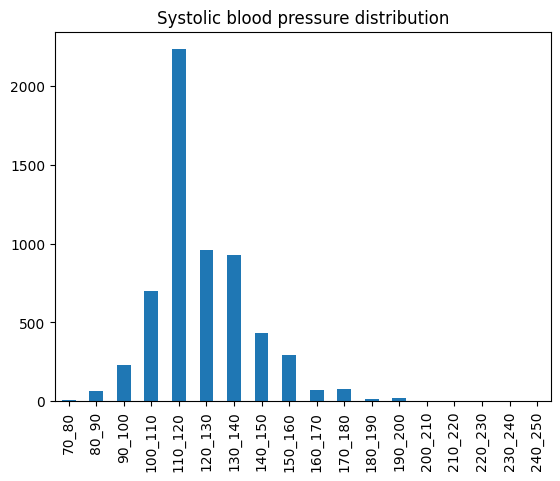

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,alco,active,cardio
14,35_40,2,181,95.0,120_130,80_90,1,1,1,1,0
19,55_60,2,162,56.0,110_120,60_70,1,1,0,1,0
38,60_65,2,162,72.0,120_130,70_80,1,1,0,1,1
58,40_45,2,172,84.0,130_140,80_90,1,1,0,1,1
59,55_60,1,164,64.0,170_180,80_90,1,1,0,1,1


In [59]:
g_s = 10  # Size of the bins

for feat, title in zip(['ap_lo', 'ap_hi'], ['Diastolic', 'Systolic']):
    bins = [i for i in range(int(train1[feat].min()-train1[feat].min()%g_s), int(train1[feat].max() + 2*g_s), g_s)]
    bin_labels = [f'{i}_{i+g_s}' for i in bins[:-1]]

    train1[feat] = cut(train1[feat], bins=bins, labels=bin_labels, include_lowest=True)

    # Plot the after
    plt.figure()
    train1[feat].value_counts().sort_index().plot(kind='bar', title= title + ' blood pressure distribution')
    plt.show()

display(train1.head())

### 4.2 - Dimensionality Reduction
We will apply dimensionality reduction techniques before fitting the synthesizer in order to circumvent difficulties of generating categorical data. A trivial choice would be directly applying PCA. While this could work, it is known that PCA does not weight categorical features appropriately, we will use Non-Negative Matrix Factorization.

In [61]:
train2 = train1.copy()

# Define a pipeline for the NMF pre-processing
num_cols = list(train2.columns[train2.nunique()>=30])
cat_cols = [i for i in train2.columns[train2.nunique()<30]]
n_comps=48
nmf_pipe = Pipeline([('scaler', RegularDataProcessor(num_cols=num_cols, cat_cols=cat_cols)),
                     ('NMF', NMF(n_components=n_comps, init='nndsvd', max_iter=2000))])

train2 = DataFrame(nmf_pipe.fit_transform(train2), columns = [f'comp_{i}' for i in range(n_comps)])

train2.head()

,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,...,comp_38,comp_39,comp_40,comp_41,comp_42,comp_43,comp_44,comp_45,comp_46,comp_47
0,0.113442,0.000000,1.631866e-01,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.707461e-01,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.166758,0.000000,0.000000e+00,1.281923e-01,0.0,3.850436e-07,0.130857,1.808200e-08,0.000000e+00,4.277740e-07,...,0.106315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.162529,0.000000,0.000000e+00,0.000000e+00,0.0,2.615259e-07,0.000000,3.069947e-08,0.000000e+00,2.065234e-07,...,0.106315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.161758,0.198244,0.000000e+00,3.582063e-08,0.0,0.000000e+00,0.000000,0.000000e+00,8.934734e-08,8.747200e-04,...,0.106315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000066,0.157398,4.391886e-07,4.333607e-07,0.0,0.000000e+00,0.130857,3.531645e-07,2.335135e-01,3.588480e-02,...,0.106312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this section we prepared two train datasets. Let's move to defining a synthesizer and we will move to the comparison from there.

## 5. Define and fit a synthesizer
From the `YData Synthetic` library we will define a Wasserstein GAN with Gradient Penalty, `WGANGP`:

In [15]:
# Define Model Parameters
batch_size = 128
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
noise_dim = 64
dim = 128

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

# Define Train Parameters
log_step = 100
epochs = 200

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

# Instantiate synthesizers
synth1 = WGAN_GP(gan_args, n_critic=5)
synth2 = WGAN_GP(gan_args, n_critic=5)

And we fit the synthesizers by running the `train` method.

In [16]:
%%capture
num_cols1 = ['height', 'weight']
synth1.train(train1, train_args, num_cols = num_cols1, cat_cols = [col for col in train1.columns if col not in num_cols1])
synth2.train(train2, train_args, num_cols = [col for col in train2.columns], cat_cols = [])

## 6. Sample and post-process synthetic data
With the fitted synthesizers we can obtain synthetic samples by leveraging the `sample` method.

In [17]:
synth_data1 = synth1.sample(len(smoker_data)).iloc[:len(smoker_data)]
synth_data2 = synth2.sample(len(smoker_data)).iloc[:len(smoker_data)]

Synthetic data generation: 100%|██████████| 48/48 [00:00<00:00, 508.51it/s]


### 6.1 - Revert dimensionality reduction
We undo the changes applied to flow 2 first by inverting the NMF transformation and the pre-processing.

In [18]:
synth_data2 = nmf_pipe.inverse_transform(synth_data2)

### 6.2 - Revert feature engineering
Both synthetic samples are in the same format. We need to undo the feature engineering step to put both in the original format.

#### Age
For age we can sample an integer uniformly within each range, add low scale normal noise and convert years back to days. This should return the spiky behavior we could verify in the real data.

In [19]:
for sample in [synth_data1, synth_data2]:
    sample['age'] = sample.age.apply(lambda x: x.split('_')[0]).astype('float') + randint(0, 5, len(sample)) + normal(0, 1/6, len(sample))
    sample['age'] = (sample.age*365).astype('int')

#### Arterial pressure features

These features don't need much, in the feature report analysis we got the suspicion that most of it is already rounded to the nearest 10.

Let's validate from the whole dataset.

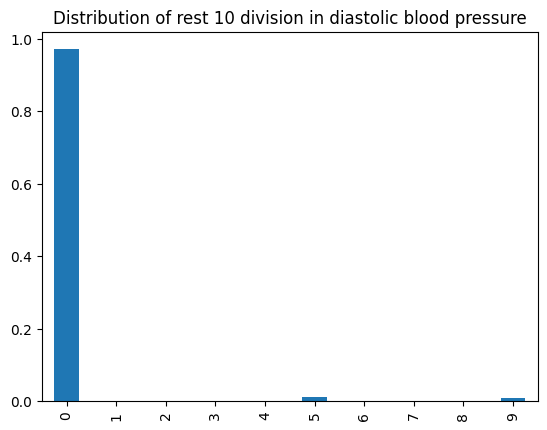

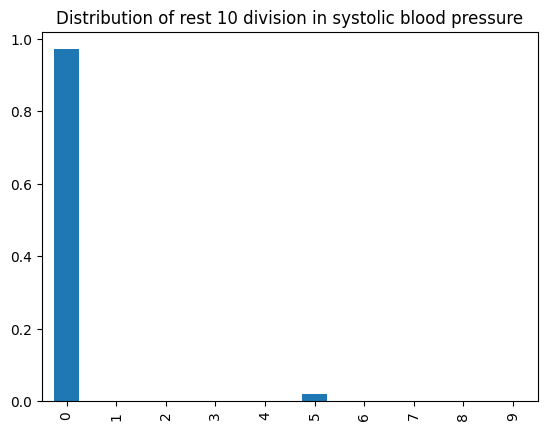

In [20]:
for feat, title in zip(['ap_lo', 'ap_hi'], ['diastolic', 'systolic']):
    # Plot the after
    plt.figure()
    (data[feat]%10).value_counts(normalize=True).sort_index().plot(kind='bar', title='Distribution of rest 10 division in '+title+' blood pressure')
    plt.show()

More than 95% of the real records are actually rounded to 0. We will use this information to simplify the post-processing.

In [21]:
for sample in [synth_data1, synth_data2]:
    sample['ap_hi'] = sample.ap_hi.apply(lambda x: x.split('_')[0])
    sample['ap_lo'] = sample.ap_lo.apply(lambda x: x.split('_')[0])
    sample['weight'] = sample['weight'].round(0).round(1)
    display(sample.head())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,alco,active,cardio
0,14957,1,172,53.0,120,90,1,2,1,0,1
1,21504,2,164,58.0,110,120,1,2,0,1,1
2,16869,2,159,62.0,210,60,2,3,0,0,0
3,19273,1,156,66.0,210,110,1,1,0,0,0
4,15355,1,167,66.0,70,100,3,1,0,1,1


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,alco,active,cardio
0,16483,2,169,75.0,130,80,2,1,0,0,1
1,15315,2,165,64.0,110,70,1,1,0,1,0
2,18209,2,164,87.0,130,80,1,1,0,1,1
3,19331,2,175,87.0,130,80,2,1,0,0,1
4,20428,2,183,85.0,130,80,1,1,1,1,1


Now the synthetic data seems to be in the original data format.

The pre and post processing operations are summarized by the following diagram:

![title](./img/processingdiagram.png)

## 7. Compare sample profiles
To compare the synthetic and real data we start by creating a profile for the synthetic samples.

In [ ]:
synth_profile1 = Profiler(synth_data1)
synth_profile2 = Profiler(synth_data2)

We can use the `plot_histograms` method to validate the quality of synthetic samples and get a preliminary inspection of the fidelity.

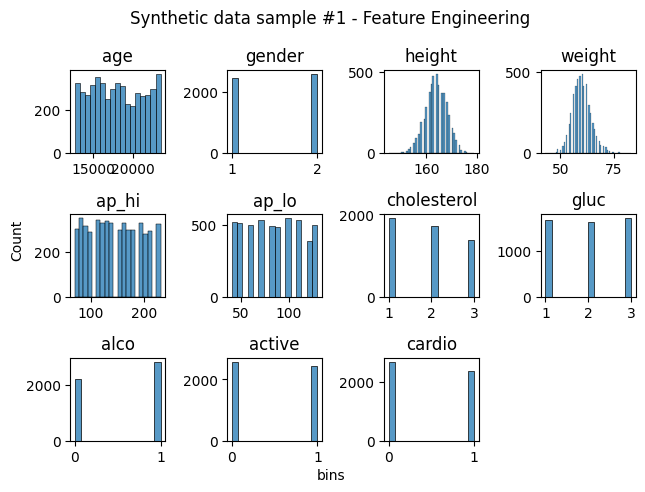

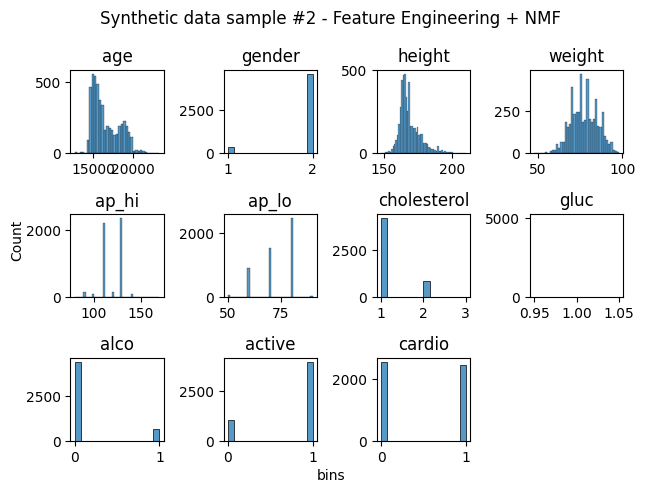

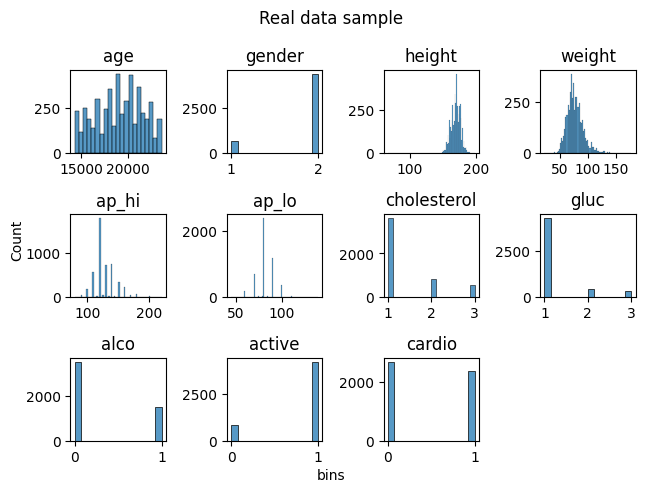

In [32]:
synth_fig1 = graphs.plot_histograms(synth_profile1)
synth_fig1.suptitle('Synthetic data sample #1 - Feature Engineering')
synth_fig1.tight_layout()

synth_fig2 = graphs.plot_histograms(synth_profile2)
synth_fig2.suptitle('Synthetic data sample #2 - Feature Engineering + NMF')
synth_fig2.tight_layout()

real_fig = graphs.plot_histograms(smoker_profile)
real_fig.suptitle('Real data sample')
real_fig.tight_layout()

plt.show()

By inspecting the marginal plots, it seems that feature engineering + NMF flow produced better results and was indeed successful in preserving the categorical distributions of the real data while flow 1 is showing a tendency towards uniform distributions. The age values seem to not be capturing the centers of mass of the distribution so well. Probably the strategy of binning by 5, sampling and adding noise took away too much information and the sampling + noise addition strategy was not able to retrieve this behavior. It seems also that glucose feature must be representing only the majority class.

The `diff` method of the `Profiler` allows us to obtain a description of the differences between two data profiles, as long as they share the same schema. This allows us to get a glimpse of the similarities between two samples, a useful way to compare synthetic samples with the real data!

In [25]:
synth_diff_report = smoker_profile.diff(synth_profile2)

In [26]:
pprint({k:v for k,v in synth_diff_report['global_stats'].items() if k!='chi2_matrix'})

{'column_count': 'unchanged',
 'correlation_matrix': None,
 'duplicate_row_count': 'unchanged',
 'encoding': 'unchanged',
 'file_type': 'unchanged',
 'profile_schema': [{},
                    {'active': 'unchanged',
                     'age': 'unchanged',
                     'alco': 'unchanged',
                     'ap_hi': 'unchanged',
                     'ap_lo': 'unchanged',
                     'cardio': 'unchanged',
                     'cholesterol': 'unchanged',
                     'gender': 'unchanged',
                     'gluc': 'unchanged',
                     'height': 'unchanged',
                     'weight': 'unchanged'},
                    {}],
 'row_count': 'unchanged',
 'row_has_null_ratio': 'unchanged',
 'row_is_null_ratio': 'unchanged',
 'samples_used': 'unchanged',
 'unique_row_ratio': 0.0013242840589305915}


The general format of the dataset is entirely kept.

In [35]:
show_feats = ['age', 'ap_hi', 'gluc']
pprint(summarize_data_stats(synth_diff_report['data_stats'],show_feats))

{'age': {'categorical': 'unchanged',
         'column_name': 'age',
         'data_label': 'unchanged',
         'data_type': 'unchanged',
         'order': 'unchanged',
         'statistics': {'max': 335.0,
                        'mean': 2490.857399999997,
                        'median': 3089.422914285711,
                        'median_absolute_deviation': 870.3677818681326,
                        'min': 1578.0,
                        'mode': [[20422.2375],
                                 [],
                                 [14995.850999999999, 15708.597000000002]],
                        'null_count': 'unchanged',
                        'null_types': 'unchanged',
                        'null_types_index': 'unchanged',
                        'sample_size': 'unchanged',
                        'stddev': 769.7272533033104,
                        'sum': 12454287.0,
                        'unique_count': 885,
                        'unique_ratio': 0.17700000000000005,
    

This output is very rich, we can unpack the following observations:
* The distribution for age is indeed off, we can see that the average and median of the differences is actually significative, close to the equivalent of 6 years
* The high blood pressure seems to be actually quite good, the standard deviation of the differences is around 6 in a feature with values ranging 80-220, also the mean and median of differences are close to 0
* In glucose we can confirm the suspicion taken from the plots, the synthetic sample is a constant value as the field `order` indicates. Well, choosing one at least it got the majority class right!

## 8. Saving/loading a profile for later analysis

`DataProfiler` also allows saving and loading profiles. This is another a useful feature for your `YData Synthetic` projects. To save a profile you can use the `Profiler`'s `save` method.

As an example, we can save the synthesizer and the synthetic data sample profile that we have just created and worry about sample evaluation or model selection after a batch of experiments.


In [ ]:
synth_profile2.save(filepath='synthetic_data_profile.pkl')
synth2.save(path='synthesizer.pkl')

Reloading data profiles with the `load` method is easy as well:

In [ ]:
synth_profile = Profiler.load(filepath='synthetic_data_profile.pkl')

## Conclusion
`DataProfiler` has a set of tools that are good additions to your Machine Learning flows.

We have seen how we can get an overall and more detailed profile of our data via plots or rich dictionaries. We have also learned how to assess the missingness of the dataset.

To compare the quality of synthetic samples we used the `diff` method that provided us with a special type of `Profiler` directed at the differences of the two samples.

We learned that training the `WGANGP` in the dense representation seemed to yield results with higher fidelity than directly learning in the data space. There are many different strategies that could have been applied to pre-processing, `DataProfiler` was useful in testing the different possibilities.

We hope this notebook has demonstrated the capacities of the `DataProfiler` package and how you can use it in the context of a `YData Synthetic` project. 